# Assignment V
**DNNs**
Fecha: 18 de octubre, 2025

**Instrucciones:** Suba sus soluciones en un archivo comprimido a Classroom antes del 28 de octubre.


## Problema 1

Lea [1] hasta la sección cinco para entender cómo se usa backpropagation para calcular el gradiente de una red neuronal respecto a sus parámetros. Luego, codifique un script en PyTorch para resolver un problema de clasificación o regresión de alguna tarea anterior, pero esta vez usando backpropagation para calcular los gradientes. Compare los resultados que obtiene con backpropagation y usando diferenciación automática. Anote sus conclusiones.









x.shape: torch.Size([1000, 1])
X_poly.shape: torch.Size([1000, 9])
y.shape: torch.Size([1000, 1])
[Manual] Epoch 1/40000 Loss: 4.036477e+00
[Manual] Epoch 100/40000 Loss: 8.835230e-01
[Manual] Epoch 200/40000 Loss: 8.765436e-01
[Manual] Epoch 300/40000 Loss: 8.702353e-01
[Manual] Epoch 400/40000 Loss: 8.643735e-01
[Manual] Epoch 500/40000 Loss: 8.588541e-01
[Manual] Epoch 600/40000 Loss: 8.536035e-01
[Manual] Epoch 700/40000 Loss: 8.485679e-01
[Manual] Epoch 800/40000 Loss: 8.437056e-01
[Manual] Epoch 900/40000 Loss: 8.389850e-01
[Manual] Epoch 1000/40000 Loss: 8.343813e-01
[Manual] Epoch 1100/40000 Loss: 8.298754e-01
[Manual] Epoch 1200/40000 Loss: 8.254520e-01
[Manual] Epoch 1300/40000 Loss: 8.210996e-01
[Manual] Epoch 1400/40000 Loss: 8.168089e-01
[Manual] Epoch 1500/40000 Loss: 8.125727e-01
[Manual] Epoch 1600/40000 Loss: 8.083853e-01
[Manual] Epoch 1700/40000 Loss: 8.042423e-01
[Manual] Epoch 1800/40000 Loss: 8.001400e-01
[Manual] Epoch 1900/40000 Loss: 7.960758e-01
[Manual] Epoch

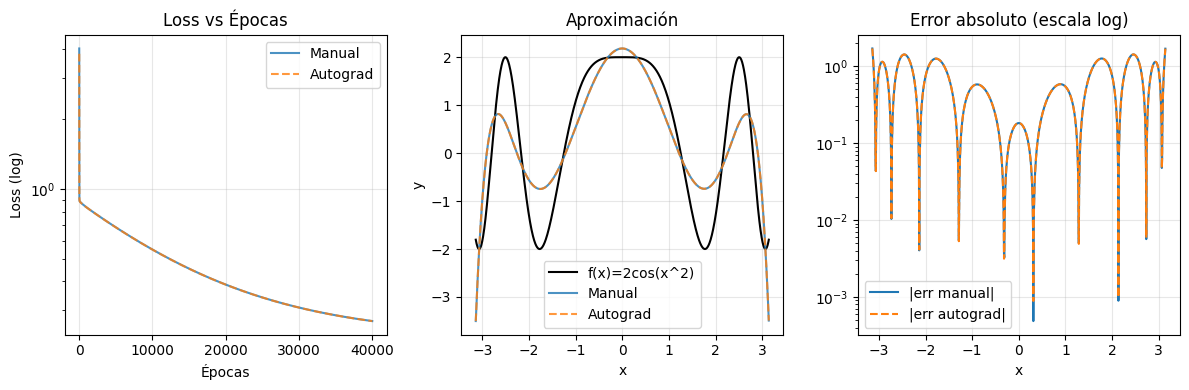


Resultados finales:
Val MSE manual:   2.699857e-01
Val MSE autograd: 2.699262e-01
Tiempo manual:   19.25 s
Tiempo autograd: 67.95 s


In [48]:
import math, time
import torch, torch.nn as nn, torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# --------------------
# Datos
# --------------------
x = torch.linspace(-math.pi, math.pi, 1000, device=device).unsqueeze(1)
y = 2 * torch.cos(x ** 2)

x_norm = x / math.pi

grado = 8
X_poly = torch.hstack([x_norm**i for i in range(grado+1)])

# Verificación de formas
print("x.shape:", x.shape)
print("X_poly.shape:", X_poly.shape)
print("y.shape:", y.shape)

# --------------------
# Inicialización
# --------------------
theta_init = torch.randn(grado+1, 1, device=device)
theta = theta_init.clone().detach()

lr = 1e-1
num_epochs = 40000
log_every = 100

train_losses_manual = []

t0 = time.time()
for epoch in range(num_epochs):
    y_pred = X_poly @ theta
    err = y_pred - y
    loss = 0.5 * (err**2).mean()
    train_losses_manual.append(loss.item())

    grad = (X_poly.T @ err) / X_poly.shape[0]
    theta = theta - lr * grad

    if (epoch == 0) or ((epoch+1) % log_every == 0):
        print(f"[Manual] Epoch {epoch+1}/{num_epochs} Loss: {loss.item():.6e}")

t_manual = time.time() - t0
print(f"⏱️ Tiempo total (manual): {t_manual:.2f} s")

model = nn.Linear(grado+1, 1, bias=True).to(device)
with torch.no_grad():
    model.weight.copy_(theta_init.view(1, -1))

optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses_auto = []

print('\n🔹 Iniciando entrenamiento autograd (nn.Linear + SGD)')
t0 = time.time()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_poly)
    loss = 0.5 * ((outputs - y)**2).mean()
    loss.backward()
    optimizer.step()
    train_losses_auto.append(loss.item())

    if (epoch == 0) or ((epoch+1) % log_every == 0):
        print(f"[Autograd] Epoch {epoch+1}/{num_epochs}  Loss: {loss.item():.6e}")

t_auto = time.time() - t0
print(f"⏱️ Tiempo total (autograd): {t_auto:.2f} s")


with torch.no_grad():
    y_pred_manual = (X_poly @ theta).cpu().numpy().ravel()
    y_pred_auto = model(X_poly).cpu().numpy().ravel()
    x_cpu = x.cpu().numpy().ravel()
    y_cpu = y.cpu().numpy().ravel()

epochs_range = np.arange(1, len(train_losses_manual) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(epochs_range, train_losses_manual, label='Manual', alpha=0.8)
plt.plot(epochs_range, train_losses_auto, label='Autograd', alpha=0.8, linestyle='--')
plt.yscale('log')
plt.xlabel('Épocas')
plt.ylabel('Loss (log)')
plt.title('Loss vs Épocas')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1,3,2)
plt.plot(x_cpu, y_cpu, label='f(x)=2cos(x^2)', color='k')
plt.plot(x_cpu, y_pred_manual, label='Manual', alpha=0.8)
plt.plot(x_cpu, y_pred_auto, label='Autograd', alpha=0.8, linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Aproximación')
plt.legend()
plt.grid(True, alpha=0.3)


plt.subplot(1,3,3)
err_manual = np.abs(y_cpu - y_pred_manual) + 1e-12
err_auto = np.abs(y_cpu - y_pred_auto) + 1e-12
plt.plot(x_cpu, err_manual, label='|err manual|')
plt.plot(x_cpu, err_auto, label='|err autograd|', linestyle='--')
plt.yscale('log')
plt.xlabel('x')
plt.title('Error absoluto (escala log)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------
# Métricas finales
# --------------------
mse_manual = np.mean((y_cpu - y_pred_manual)**2) / 2.0
mse_auto = np.mean((y_cpu - y_pred_auto)**2) / 2.0

print('\nResultados finales:')
print(f'Val MSE manual:   {mse_manual:.6e}')
print(f'Val MSE autograd: {mse_auto:.6e}')
print(f'Tiempo manual:   {t_manual:.2f} s')
print(f'Tiempo autograd: {t_auto:.2f} s')




## Problemas 2 a 9

Lea todas las referencias en este enunciado. Estudian aspectos relevantes de modelos de redes neuronales. Luego, haga un resumen de cada una de ellas describiendo los siguientes puntos:

- ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?
- ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?
- ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas?
- Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?

Referencias:

[1] Catherine F. Higham, Desmond J. Higham, Deep Learning: An Introduction for Applied Mathematicians, SIAM, Vol. 61, No. 4, pp. 860–891, 2019.

[2] G. Cybenko. Approximation by superpositions of a sigmoidal function, Mathematics of Control, Signals, and Systems, 1989, 2 (4), pp.303-314. DOI:10.1007/BF02551274.

[3] Maithra Raghu, et. al. On the expressive power of deep neural networks, ICML’17, 2017.

[4] Shiv Ram Dubey, Satish Kumar Singh, Bidyut Baran Chaudhuri, Activation Functions in Deep Learning: A Comprehensive Survey and Benchmark, Arxiv 2021.

[5] Prajit Ramachandran, Barret Zoph, Quoc V. Le, Searching for Activation Functions, Arxiv 2017.

[6] Sergey Ioffe, Christian Szegedy, Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift, ICML 2015.

[7] Shibani Santurkar, Dimitris Tsipras, Andrew Ilyas, Aleksander Madry, How Does Batch Normalization Help Optimization?, NeurIPS 2018.

[8] Siddharth Krishna Kumar, On weight initialization in deep neural networks, ArXiv 2017.



# Estructura para Problemas 2 a 9

A continuación se presenta la plantilla que deben usar para responder cada problema (Problema 2 → Referencia [1], Problema 3 → Referencia [2], ..., Problema 9 → Referencia [8]).

Para cada problema copie la sección correspondiente y complete allí las respuestas (a modo de guía, aquí sólo se deja la estructura — NO RESPONDA las preguntas en esta celda):

---

## Problema 2 — Referencia [1]
Referencia: Catherine F. Higham, Desmond J. Higham, "Deep Learning: An Introduction for Applied Mathematicians", SIAM, 2019.

**1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?**

El problema critico que el artículo intenta resolver, en este caso no existe, es un articulo que aborda la necesidad de 
explicar el aprendizaje profundo con matemáticas. Se centra en tres preguntas clave: ¿qué es una red neuronal profunda?, ¿cómo se entrena?, y ¿cómo funciona el descenso de gradiente estocástico (SGD)?

A su vez la importancia de este paper radica en que el aprendizaje profundo al revolucionar muchos campos, es necesario 
entender fundamentos matematicos para crear sistemas de aprendizaje robustos los cuales puedan ser explicados y entendidos.

**2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?**

Es un recurso pedagogico le cual emplea matematicas para explicar conceptos de aprendizaje profundo, lo cual es una ventaja
ya que permite entender los fundamentos de las redes neuronales profundas.

Si se puede ver alguna desventaja quizá es el tema de que no es un artículo que propone una nueva idea o solución a un problema, sino que es más bien una revisión explicativa.

Su fortaleza es la claridad: presenta conceptos clave (arquitecturas de red, retropropagación, SGD) con ejemplos simples en MATLAB y demostraciones de software.

**3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?**

Las ideas presentadas en el artículo se pueden implementar en PyTorch utilizando las funciones y módulos existentes para construir y entrenar redes neuronales profundas. PyTorch proporciona una amplia gama de herramientas para definir arquitecturas de redes, optimizar parámetros y realizar el descenso de gradiente estocástico.

```python
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleNet(nn.Module):
def __init__(self, input_dim, hidden_dim, output_dim):
    super().__init__()
    self.net = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.Sigmoid(),
    nn.Linear(hidden_dim, output_dim),
    nn.Sigmoid())


def forward(self, x):
    return self.net(x)


model = SimpleNet(input_dim=2, hidden_dim=4, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


for epoch in range(100):
    inputs = torch.randn(10, 2)
    labels = torch.randint(0, 2, (10,))
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

**4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?**

La idea del artículo es útil en contextos educativos y de investigación donde se busca una comprensión más profunda de los fundamentos matemáticos del aprendizaje profundo. Puede ser especialmente valiosa para estudiantes y profesionales que deseen desarrollar modelos más robustos y explicables basados en el funcionamiento interno de las redes neuronales.

---

## Problema 3 — Referencia [2]
Referencia: G. Cybenko, "Approximation by superpositions of a sigmoidal function", 1989.

**1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?**

Cybenko plantea y resuleve el problema de la capacidad de las redes neuronales para aproximar funciones continuas. Demuestra que una red neuronal con una sola capa oculta y funciones de activación sigmoides puede aproximar cualquier función continua.

Proporciona lo que es una base teorica pues da certeza de la efectividad de las redes neuronales en tareas de aproximación de funciones, lo cual es fundamental para su aplicación en aprendizaje automático.

**2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?**

La idea de Cybenko es fundamental para establecer la base teórica del aprendizaje profundo. Una ventaja es que proporciona garantías sobre la capacidad de las redes neuronales para aproximar funciones complejas. Sin embargo, una desventaja es que no aborda la eficiencia computacional ni la necesidad de múltiples capas para funciones más complejas o la cantidad de nodos en la capa oculta que se necesitan para un caso concreto.

**3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?**

Las ideas de Cybenko se pueden implementar en PyTorch utilizando redes neuronales con una sola capa oculta y funciones de activación sigmoides. PyTorch permite construir fácilmente estas arquitecturas y entrenarlas con datos.

```python
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


model = SimpleNet(input_dim=2, hidden_dim=4, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


for epoch in range(100):
    inputs = torch.randn(10, 2)
    labels = torch.randint(0, 2, (10,))
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

**4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?**

Cybenko demostró que una red neuronal **con una sola capa oculta y función sigmoide** puede aproximar **cualquier función continua**  

$$
f:[0,1]^n \to \mathbb{R}
$$

con precisión arbitraria:

$$
F(x)=\sum_{i=1}^{N}\alpha_i\,\sigma(w_i^T x+\theta_i)
\quad \text{tal que} \quad |F(x)-f(x)|<\varepsilon
$$

**Utilidad:**
- Las combinaciones de sigmoides forman una **base densa** en el espacio de funciones continuas.  
- Usa fundamentos del **Teorema de Hahn–Banach** y la **dualidad de Riesz**.  
- Es la **base teórica** del aprendizaje profundo: garantiza que las redes pueden modelar **cualquier relación compleja** entre variables.
---

## Problema 4 — Referencia [3]
Referencia: Maithra Raghu, et al., "On the expressive power of deep neural networks", ICML 2017.

1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?

2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?

3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?

4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?

---

## Problema 5 — Referencia [4]
Referencia: Shiv Ram Dubey, Satish Kumar Singh, Bidyut Baran Chaudhuri, "Activation Functions in Deep Learning: A Comprehensive Survey and Benchmark", arXiv 2021.

1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?

2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?

3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?

4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?

---

## Problema 6 — Referencia [5]
Referencia: Prajit Ramachandran, Barret Zoph, Quoc V. Le, "Searching for Activation Functions", arXiv 2017.

1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?

2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?

3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?

4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?

---

## Problema 7 — Referencia [6]
Referencia: Sergey Ioffe, Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", ICML 2015.

1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?

2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?

3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?

4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?

---

## Problema 8 — Referencia [7]
Referencia: Shibani Santurkar, Dimitris Tsipras, Andrew Ilyas, Aleksander Madry, "How Does Batch Normalization Help Optimization?", NeurIPS 2018.

1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?

2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?

3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?

4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?

---

## Problema 9 — Referencia [8]
Referencia: Siddharth Krishna Kumar, "On weight initialization in deep neural networks", arXiv 2017.

1) ¿Cuál es el problema crítico que el artículo intenta resolver? ¿Por qué es relevante resolverlo?

2) ¿Qué opina sobre la idea propuesta? ¿Qué ventajas y desventajas nota?

3) ¿Cómo se pueden implementar esas ideas y usar en PyTorch? ¿Ya están implementadas (bibliotecas, funciones existentes)?

4) Identifique en qué circunstancias conviene aplicar la idea del artículo. ¿Cómo puede serle útil?

---

*Instrucciones de uso:* Copie cada sección a continuación del enunciado correspondiente en su cuaderno, y responda a las cuatro preguntas para cada referencia. Mantenga la citación bibliográfica completa en la parte superior de cada respuesta.

